# TEACHER MODEL

## Imports

In [0]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import cifar100, cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import Sequence
from keras import regularizers
import os

import time
import h5py

import colorsys #enables us to convert a rgb vector to a hsv vector
from skimage.color import rgb2hsv, hsv2rgb
from skimage.io import imread
from skimage.transform import resize

import cv2

# to make this notebook's output stable across runs

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Using TensorFlow backend.


### Import Dataset : choose between CIFAR_10 and CIFAR_100


In [0]:
#Loading the dataset

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print('x_train shape:', x_train.shape)


#Define the number of classes that you want to use

num_classes = 10
#num_classes = 100

169009152/169001437 [==============================] - 101s 1us/step
x_train shape: (50000, 32, 32, 3)


## 1- Creation of the dataset to build the distillation

### Definitions of the different functions used in this ipynb

In [0]:
# random crop needed for training augmentation
def random_crop(img):
    height, width, _ = img.shape
    dy, dx = input_size, input_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    img = img[y:(y+dy), x:(x+dx), :]
    return img

# center crop needed for testing (validation & test sets)
def center_crop(img):
    height, width, _ = img.shape
    dy, dx = input_size, input_size
    x = int((width - dx + 1)/2)
    y = int((height - dy + 1)/2)
    img = img[y:(y+dy), x:(x+dx), :]
    return img

### Preparation of the data for Keras


In [0]:
#Divide into training and validation set

x_validation = x_train_bis[40000:]
x_train_bis = x_train_bis[:40000]


#Define input size for the data augmentation : we will keep input_size pixels after data augmentation
input_size = 28

### Cropping the images
X_train = np.zeros((np.shape(x_train_bis)[0],input_size,input_size,3))

#random crop for training set
for i in range(np.shape(x_train_bis)[0]):
  X_train[i] = random_crop(x_train_bis[i])
  
X_validation = np.zeros((np.shape(x_validation)[0],input_size,input_size,3))

#center crop for validation set, no need for data augmentation, just input_size size images
for i in range(np.shape(x_validation)[0]):
  X_validation[i] = center_crop(x_validation[i])
  
### Normalizing the data

X_train = X_train.astype('float32')
x_test = x_test.astype('float32')
X_validation = X_validation.astype('float32')
X_train /= 255
x_test /= 255
X_validation /= 255

y_train_soft = without_softmax_model.predict(X_train, batch_size=32, verbose=0, steps=None)
y_validation_soft = without_softmax_model.predict(X_validation, batch_size=32, verbose=0, steps=None)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

x_validation shape: (10000, 32, 32, 3)
y_validation shape: (10000, 1)


## 2-Data Augmentation

#### First version

In [0]:
#Parameters of Data Augmentation
Dh = 0.06
Ds = 0.26
Dv = 0.20
As = 0.21
Av = 0.13

augmented_x_train = []

#Needed for Data Augmentation, we want to convert one image in rgb to hsv scale
def image_rgb_to_hsv(image_rgb): #We need to put a sample of image (32,32,3)
  nb_line = np.shape(image_rgb)[0]
  hsv_image = np.zeros((nb_line,nb_line,3))
  
  #Substracting the mean of the image and dividing by the standard deviation
  image_rgb = image_rgb - np.mean(image_rgb) #So far we compute the mean of the whole image, rather than doing it separately for each channel RGB
  image_rgb = image_rgb/np.std(image_rgb) #Same thing
  
  #Creating random values from an uniform distribution
  #Shifting values
  delta_h = np.random.uniform(-Dh,Dh)
  delta_s = np.random.uniform(-Ds,Ds)
  delta_v = np.random.uniform(-Dv,Dv)

  #Scaling values
  a_s = np.random.uniform(1/(1+As),1+As)
  a_v = np.random.uniform(1/(1+Av),1+Av)
  
  
  for i in range(nb_line):
    for j in range(nb_line):
      
      hsv_image[i,j,:] = colorsys.rgb_to_hsv(image_rgb[i,j,0],image_rgb[i,j,1],image_rgb[i,j,2])
      
  #Scaling and shifting the values
  hsv_image[:,:,0] += delta_h
  hsv_image[:,:,1] = hsv_image[:,:,1]/a_s+delta_s
  hsv_image[:,:,2] = hsv_image[:,:,2]/a_v+delta_v
  
  #Left-right symmetry of the image with a probability of 0.5
  if np.random.uniform(0,1) > 0.5:
    hsv_image = np.flip(hsv_image,axis=1)
  
  #Cropping the image
  S = np.random.randint(24, 32)
  x = np.random.randint(0, 32-S)
  y = np.random.randint(0, 32-S)
  
  #Resizing back to 32x32
  
  hsv_image = hsv_image[x:x+S, y:y+S, :]
  hsv_image = cv2.resize(hsv_image, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
      
  return hsv_image

#### Second version

In [0]:
#Parameters of Data Augmentation
#Dh = 0.02
#Ds = 0.02
#Dv = 0.02
#As = 0.02
#Av = 0.02

#Needed for Data Augmentation, we want to convert one image in rgb to hsv scale
def image_rgb_to_hsv2(img_rgb): #We need to put a sample of image (32,32,3) in [0,1]
    #Creating random values from an uniform distribution
    
    # Shifting values
    delta_h = np.random.uniform(-Dh,Dh)
    delta_s = np.random.uniform(-Ds,Ds)
    delta_v = np.random.uniform(-Dv,Dv)
    
    # Scaling values
    a_s = np.random.uniform(1-As,1+As)
    a_v = np.random.uniform(1-Av,1+Av)
    
    # normalization & color space conversion
    # img_rgb = np.clip((img_rgb - img_rgb.mean())/img_rgb.std(),0,1)
    img_hsv = rgb2hsv(img_rgb)
    
    # Scaling and shifting the values
    img_hsv[:,:,0] = (img_hsv[:,:,0] + delta_h) % 1
    img_hsv[:,:,1] = img_hsv[:,:,1]/a_s+delta_s
    img_hsv[:,:,2] = img_hsv[:,:,2]/a_v+delta_v
    img_hsv = np.clip(img_hsv, 0, 1)

    # Left-right symmetry of the image with a probability of 0.5
    if np.random.uniform(0,1) > 0.5:
        img_hsv = np.flip(img_hsv,axis=1)

    #Cropping the image
    #S = np.random.randint(24, 32)
    S = 28
    x = np.random.randint(0, 32-S)
    y = np.random.randint(0, 32-S)

    #Resizing back to 32x32
    img_hsv = img_hsv[x:x+S, y:y+S, :]
    img_hsv = resize(img_hsv, (32, 32))

    return hsv2rgb(img_hsv)

img = x_train[0]/255
new = image_rgb_to_hsv2(x_train[0]/255)
print("Input image pixel range : {}, {}".format(img.min(), img.max()))
print("Output image pixel range : {}, {}".format(new.min(), new.max()))
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(new)
plt.show()

## 3- Train the teacher model

#### LOAD DATA AND DEFINE MODEL

In [0]:
reset_graph(seed=42)
tf.keras.backend.clear_session()

### PARAMETERS

batch_size = 32 
epochs = 100
num_classes = 100
input_size = 28
data_augmentation = True
num_predictions = 20

### SAVE THE MODEL
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar_100_teacher.h5'


### LOAD THE DATA

# The data, split between train and test sets:
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_validation = x_train[40000:]
x_train = x_train[:40000]
print('x_validation shape:', x_validation.shape)

y_validation = y_train[40000:]
y_train = y_train[:40000]
print('y_validation shape:', y_validation.shape)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_validation = keras.utils.to_categorical(y_validation, num_classes)

### CHOOSE THE MODEL

model = Sequential()

model.add(Conv2D(76, (3, 3), padding='same',input_shape=(input_size,input_size,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(76, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(126, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(126, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

model.add(Conv2D(148, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(148, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(148, (3, 3), padding='same')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(148, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.37))

model.add(Flatten())
model.add(Dense(1200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.42))
model.add(Dense(1200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.42))

model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

x_validation shape: (10000, 32, 32, 3)
y_validation shape: (10000, 1)
x_train shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 76)        2128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 76)        304       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 76)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 76)        52060     
_________________________________________________________________
batch_norm

#### TRAIN THE MODEL

In [0]:
# initiate RMSprop optimizer
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_validation = x_validation.astype('float32')
x_train /= 255
x_test /= 255
x_validation /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    
    validation_and_test_datagen = ImageDataGenerator()

    
        # Batch generators
    train_generator = train_datagen.flow(
        x_train, 
        y_train,
        batch_size=batch_size,
    )

    validation_generator = validation_and_test_datagen.flow(
        x_validation, 
        y_validation, 
        batch_size=batch_size,
    )
    
    
        # this class is needed to adapt keras pipeline to shape modifications
    class crop_gen(Sequence):

        def __init__(self, gen):
            self.gen = gen
            self.x, self.y = next(gen)
            self.batch_size = batch_size

        def __len__(self):
            return self.gen.__len__()

        def __getitem__(self, idx):
            batch_x, batch_y = next(self.gen)
            batch_crops = np.zeros((batch_x.shape[0], input_size, input_size, 3))
            for i in range(batch_x.shape[0]):
                batch_crops[i] = random_crop(batch_x[i])
            return batch_crops, batch_y

    # this class is needed to adapt keras pipeline to shape modifications    
    class crop_gen_center(Sequence):

        def __init__(self, gen):
            self.gen = gen
            self.x, self.y = gen.__getitem__(0)
            self.batch_size = batch_size
            #self.classes = gen.classes
            self.class_indices = np.arange(num_classes) #gen.class_indices

        def __len__(self):
            return self.gen.__len__()


        def __getitem__(self, idx):
            batch_x, batch_y = next(self.gen)
            batch_crops = np.zeros((batch_x.shape[0], input_size, input_size, 3))
            for i in range(batch_x.shape[0]):
                batch_crops[i] = center_crop(batch_x[i])
            return batch_crops, batch_y
          
    train_generator = crop_gen(train_generator)
    validation_generator = crop_gen_center(validation_generator)

    # Fit the model on the batches generated by datagen.flow().
    print('x_train shape:', x_train.shape)
    print('x_validation shape:', x_validation.shape)
    history = model.fit_generator(
      train_generator,
      epochs=epochs,
      shuffle=True,
      validation_data=validation_generator,
      validation_steps = len(x_validation)/batch_size,
      steps_per_epoch = len(x_train)/batch_size,
      workers=4
)
    
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)


X_test = np.zeros((np.shape(x_test)[0],input_size,input_size,3))

for i in range(np.shape(x_test)[0]):
  X_test[i] = center_crop(x_test[i])
  
  # Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
x_train shape: (40000, 32, 32, 3)
x_validation shape: (10000, 32, 32, 3)
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1250/1250 [==============================] - 38s 31ms/step - loss: 4.4212 - acc: 0.0636 - val_loss: 3.9010 - val_acc: 0.0992
Epoch 2/100
1250/1250 [==============================] - 33s 26ms/step - loss: 3.8276 - acc: 0.1218 - val_loss: 3.4028 - val_acc: 0.1798
Epoch 3/100
1250/1250 [==============================] - 34s 27ms/step - loss: 3.4719 - acc: 0.1687 - val_loss: 3.1718 - val_acc: 0.2110
Epoch 4/100
1250/1250 [==============================] - 33s 27ms/step - loss: 3.2244 - acc: 0.2071 - val_loss: 3.0696 - val_acc: 0.2399
Epoch 5/100
1250/1250 [==============================] - 33s 26ms/step - loss: 2.9920 - acc: 0.2492 - val_loss: 2.7200 - val_acc: 0.3079
Epoch 6/100
1250/1250 [==============================] - 32s 25ms/step - loss: 2.8206 - acc: 0.2803 - val_loss: 2.7895 - val_acc: 0.2988
Epoch 7/100
1250/1250 

#### PRINT ACCURACY OF THE MODEL

In [0]:
X_test = np.zeros((np.shape(x_test)[0],input_size,input_size,3))

for i in range(np.shape(x_test)[0]):
  X_test[i] = center_crop(x_test[i])
  
  # Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 145us/step
Test loss: 1.4036770114898682
Test accuracy: 0.6382


#### PLOT THE MODEL ACCURACY

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


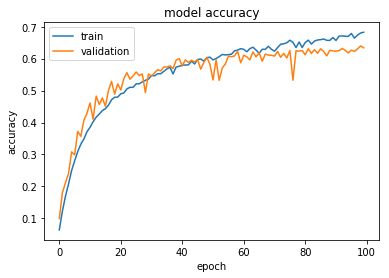

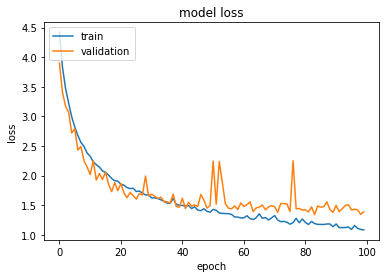

In [0]:
# list all data in historys
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()